In [1]:
! nvidia-smi

Mon May  8 20:05:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    31W /  70W |   7735MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
from spellbook.parallel import get_experiment_name

from train_pipeline import train, _train_seed

import os
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

from IPython.display import clear_output



from spellbook.parallel import _parallel_model_tag
from spellbook import count_parameters

    

def get_experiment_name(cfg):
    nparams=count_parameters(instantiate(cfg.model, out_features=3))
    return f'{cfg.logging.experiment_name}__{_parallel_model_tag(cfg)}__nparams={nparams}'


In [16]:
import torch
from torch import nn
import torch.nn.functional as F

import os
import math
import numpy as np

def init_siren(W, fan_in, omega=30, init_c=24, flic=2, is_first=False):
    if is_first:
        c = flic / fan_in
    else:
        c = np.sqrt(init_c / fan_in) / omega
    W.uniform_(-c, c)

def _init(W, c):
    W.uniform_(-c, c)

class SplitLayer(nn.Module):
    def __init__(self, input_dim, output_dim, m=1.0, cs=(1,1,1,1), omegas=(1, 1, 1.0, 1), use_bias=True):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim * 4, bias=use_bias)
        self.dropout = nn.Dropout(0)
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.m = m
        self.omegas = omegas
        self.cs = cs

        self.init_weights()
        
        

    
    def init_weights(self):
        self.linear.bias.data.uniform_(0, 0)
        s = self.output_dim
        W = self.linear.weight.data
        _init(W[:s], self.cs[0])
        _init(W[s:s*2], self.cs[1])
        _init(W[s*2:s*3], self.cs[2])
        _init(W[s*3:s*4], self.cs[3])


    def forward(self, x):
        h, acts = self.forward_with_activations(x)
        return h

    def forward_with_activations(self, x):
        preact = self.linear(x)
        preacts = preact.chunk(4, dim=-1)
        preacts = list(preacts)

        for i in range(len(preacts)):
            preacts[i] = self.omegas[i] * preacts[i]

        preact_tanh, preact_sigmoid, preact_sin, preact_cos = preacts
        act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(), preact_sin.sin(), preact_cos.cos()
        h = act_tanh * act_sigmoid * act_sin * act_cos

        h = h * self.m

        return h, [x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]


class SimpleSplitNet(nn.Module):
    def __init__(self, cs, use_bias=True, omegas=(1, 1, 1.0, 1), m=1.0):
        super().__init__()

        in_features = 128
        hidden_layers = 2
        
        if not hasattr(m, '__len__'):
            m = [m] * (len(hidden_layers)+1)
            
        is_layerwise_omegas = hasattr(omegas[0], '__len__')
        
        if not is_layerwise_omegas:
            omegas = [omegas] * (len(hidden_layers)+1)


        
        net = [
            SplitLayer(in_features, 64, use_bias=use_bias, cs=cs[0], m=m[0], omegas=omegas[0]),
            SplitLayer(64, 32, use_bias=use_bias, cs=cs[1], m=m[1], omegas=omegas[1]),
            nn.Linear(32, 3)
        ]

        _init(net[-1].weight.data, cs[2])
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

    def forward_with_activations(self, x):
        h = x
        intermediate_acts = []

        for layer in self.net:
            if isinstance(layer, SplitLayer):
                h, acts = layer.forward_with_activations(h)
            else:
                h = layer(h)
                acts = []

            intermediate_acts.append((h, acts))

        return h, intermediate_acts


class ParallelSplitNet(nn.Module):
    def __init__(self, model_configs, out_features, encoding_size=128):
        super().__init__()

        #         if not hasattr(m, '__len__'):
        #             m = [m] * (hidden_layers+2)

        import rff

        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoding_size)
        in_features = encoding_size * 2
        self.networks = nn.ModuleList([SimpleSplitNet(**k, in_features=in_features, out_features=out_features) for k in model_configs])

    def forward(self, x):
        x = self.encoding(x)
        o = 0

        for net in self.networks:
            o = o + net(x)

        return o


In [17]:
kwargs = {
    'cs': [(1,1,1,1), (1,1,1,1), 0.1],
    'omegas': [(1,1,1,1), (1,1,1,1)],
    'm': [1, 1]
}

net = SimpleSplitNet(**kwargs)

+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    256     |
| networks.0.net.1.linear.weight |    8192    |
|  networks.0.net.1.linear.bias  |    128     |
|    networks.0.net.2.weight     |     96     |
|     networks.0.net.2.bias      |     3      |
+--------------------------------+------------+
Total Trainable Params: 41443
Setting seed to 0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


********************************************************************************


image: tokyo512.png
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
model:
  _target_: spellbook.parallel.ParallelSplitNet
  encoding_size: 64
  model_configs:
  - hidden_layers:
    - 64
    - 32
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet__[128],64,32__nparams=41443
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0


********************************************************************************
+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   32768    |
|  networks.0.net.0.linear.bias  |    256     |
| networks.0.net.1.linear.weight |    8192    |
|  networks.0.net.1.

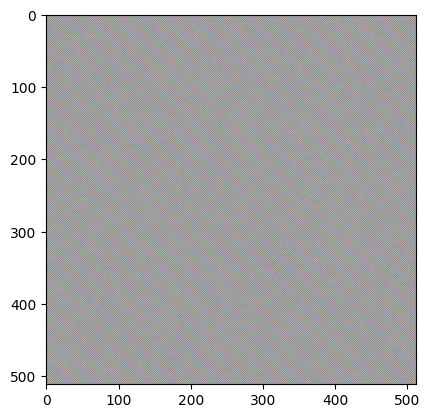

Step 500, Total loss 0.213381


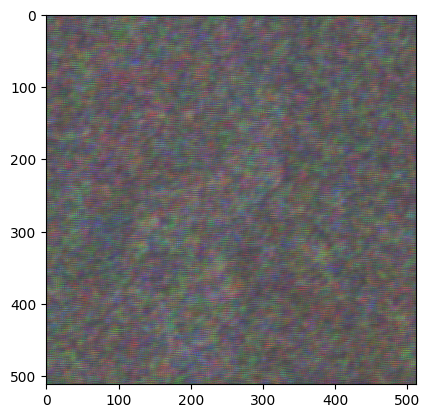

Step 1000, Total loss 0.043930


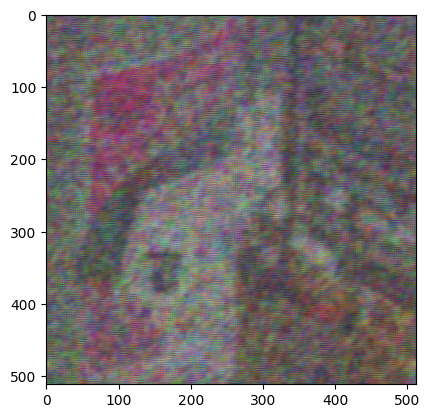

Step 1500, Total loss 0.028217


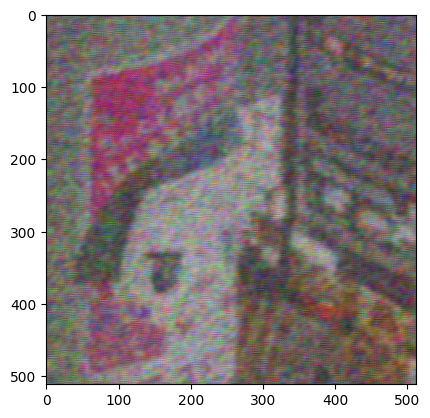

Step 2000, Total loss 0.021841


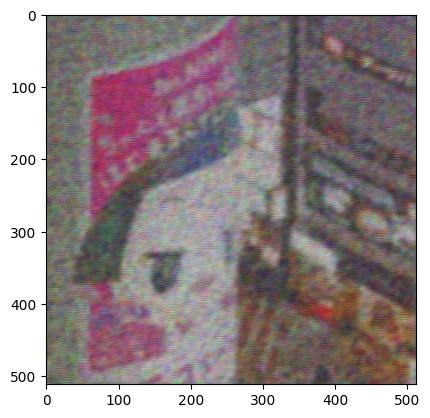

Step 2500, Total loss 0.018237


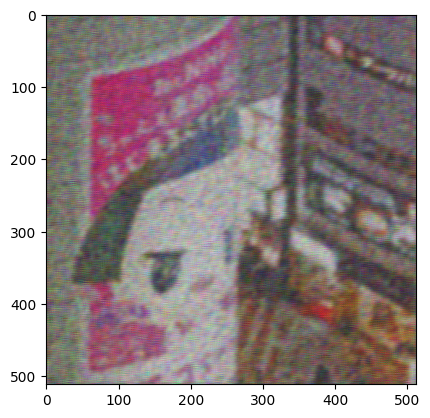

In [3]:
cfg = load_cfg(overrides=[
    "+exp=04_parallel",
    "model.model_configs=[{hidden_layers: [64, 32]}]",
    "+device=cuda:0",
])

# cfg.model.model_configs[0] = {'hidden_layers': [32, 16],
#    'm': 10.0,
#    # 'omegas': [[2.689339192708333,
#    #   16.50197957356771,
#    #   6.805110168457031,
#    #   6.799144490559896],
#    #  [8.467052205403645,
#    #   42.76984456380208,
#    #   12.20421142578125,
#    #   14.096522013346354]]
#                 }

cfg.logging.experiment_name = get_experiment_name(cfg)
cfg.random_seed = [0]

# print(OmegaConf.to_yaml(cfg))
train(cfg)

In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [ ]:
for h in ([64,128,256,512]):
    for nh in [1,2,3,4,5]:
        cfg = load_cfg(overrides=[
            "+device=cuda:0",
            f'model.hidden_layers={nh}',
            f'model.hidden_features={h}'
        ])

        cfg.logging.experiment_name=get_experiment_name(cfg)

        # print(OmegaConf.to_yaml(cfg))
        train(cfg)

In [ ]:
! ls ../../data